# El problema TSP - Dwave 102

V1.0 Mayo 2023

### El problema TSP

En el campo matemático de la teoría de grafos, un grafo completo es un grafo simple no dirigido en el que cada par de vértices distintos está conectado por una única arista. 

La librería `dwave_networkx` proporciona un algoritmo TSP, `traveling_salesperson()`, que resuelve el clásico problema del viajante o tsp, pasándole como argumento un grafo completo, con pesos no nulos.

El problema se aborda mediante el formalismo qubo, intentando encontrar el estado fundamental de la función de coste. Por la naturaleza de un solver (evolución adiabática no garantizada), la solución puede no corresponder al estado de mínima energía, pero sí es esperable que en todo caso se le aproxime.

Se puede introducir en el formalismo multiplicadores de Lagrange para penalizar la violación de su restricción fundamental: no visitar un nodo más de una vez. En caso contrario se priorizará la obtención de un valor de energía mínimo, es decir, de un recorrido total mínimo.


https://docs.ocean.dwavesys.com/projects/dwave-networkx/en/latest/reference/algorithms/generated/dwave_networkx.algorithms.tsp.traveling_salesperson.html

Limitaciones y sugerencias:

https://medium.com/@michal.stechly/solving-the-traveling-salesman-problem-using-quantum-computer-bb00438de223

https://support.dwavesys.com/hc/en-us/community/posts/360028972434

In [34]:
#Entorno y funciones auxiliares

import dimod
import networkx as nx
import matplotlib.pyplot as plt
import dwave_networkx as dnx


def grafo_tsp(nodos):
    G = nx.Graph()
    G.add_weighted_edges_from(nodos)

    pos = nx.spring_layout(G,seed=15)
    labels = nx.get_edge_attributes(G, 'weight')
    nx.draw_networkx(G, pos, width=1, linewidths=1,
    node_size=800, alpha=0.6,with_labels=True)

    nx.draw_networkx_edge_labels(G,pos,font_color='red',edge_labels=labels)

    plt.show()
    return G


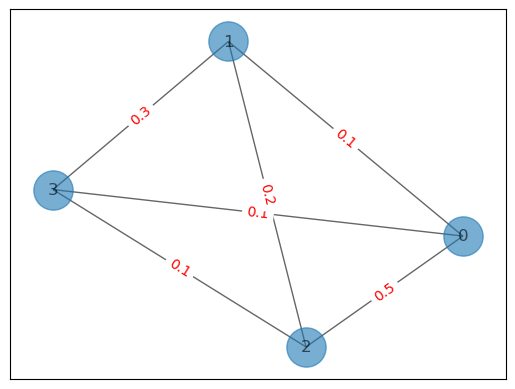

In [35]:
# Definición del problema TSP


nodos_tsp={(0, 1, .1), (0, 2, .5),(0, 3, .1), 
           (1, 2, .2),(1, 3, .3),
           (2, 3, .1)}

gTSP=grafo_tsp(nodos_tsp)

#### Comentarios:

- El recorrido de menor peso total, 0.3, corresponde a  [1,0,3,2] o [2,3,0,1]
- Con peso 0.4, recorridos cuasi óptimos, hay varias alternativas.

#### Solver analítico

In [23]:
# gTSP con nodo inicial fijado

for nodo in range(4):
    print(nodo,dnx.traveling_salesperson(gTSP, dimod.ExactSolver(),start=nodo))


0 [0, 3, 2, 1]
1 [1, 0, 3, 2]
2 [2, 1, 0, 3]
3 [3, 2, 1, 0]


#### QSolver

In [14]:
from dwave.cloud import Client

#solvers disponibles según cuenta de usuario

def client_info():
    print("Solvers:")
    for solver in Client.from_config().get_solvers():
        print(solver)

In [15]:
client_info()

Solvers:
BQMSolver(id='hybrid_binary_quadratic_model_version2')
DQMSolver(id='hybrid_discrete_quadratic_model_version1')
CQMSolver(id='hybrid_constrained_quadratic_model_version1')
StructuredSolver(id='Advantage2_prototype1.1')
StructuredSolver(id='Advantage_system6.2')
StructuredSolver(id='Advantage_system4.1')


In [24]:
# Con QSampler asignado y nodo inicial dado

from dwave.system import DWaveSampler
from dwave.system import EmbeddingComposite

d_sampler=EmbeddingComposite(DWaveSampler())

for nodo in range(4):

    print(nodo,dnx.traveling_salesperson(gTSP,d_sampler,start=nodo))

0 [0, 3, 1, 3]
1 [1, 1, 2, 3]
2 [2, 1, None, 3]
3 [3, 2, 2, 0]


In [29]:
# Con QSampler Advantage_system6.2

d_sampler = EmbeddingComposite(DWaveSampler(solver = "Advantage_system6.2"))

for nodo in range(4):

    print(nodo,dnx.traveling_salesperson(gTSP,d_sampler,start=nodo))

0 [0, 1, 2, 3]
1 [1, 3, 2, 0]
2 [2, 0, 1, 3]
3 [3, 2, 1, 0]


In [28]:
# Con QSampler Advantage2_prototype1.1

d_sampler = EmbeddingComposite(DWaveSampler(solver = "Advantage2_prototype1.1"))

for nodo in range(4):

    print(nodo,dnx.traveling_salesperson(gTSP,d_sampler,start=nodo))

0 [0, 3, 1, 2]
1 [1, 0, 3, 2]
2 [2, 0, 3, 1]
3 [3, 2, 1, 0]


### Conclusiones

- Los solvers analíticos (fuerza bruta) producen resultados óptimos.
- Los solvers hard producen resultados con mucha dispersión, con soluciones óptimas, pero también soluciones con nodos repetidos y otras nada óptimas.


Así pues, out-of-the-box no es una herramienta útil.